In [1]:
import numpy as np
import pandas as pd

In [2]:
abc_df = pd.read_csv('ABC_Feature_Matrix_Random.csv')
jwst_df = pd.read_csv('Interpolated_WASP-39b.csv')

In [3]:
x_spec = abc_df.iloc[:, 1:53]
y = abc_df.iloc[:, 53]

In [4]:
x_jwst = jwst_df.iloc[:,1:]

In [5]:
#Train Test Split
from sklearn.model_selection import train_test_split
x_spec_train, x_spec_test, y_train, y_test = train_test_split(x_spec, y, test_size = 0.2, random_state = 42)

In [6]:
X_train = x_spec_train.to_numpy()
X_test = x_spec_test.to_numpy()
X_jwst = x_jwst.to_numpy()

In [7]:
#Manual Normalisation - numpy
means_tr = X_train.mean(axis=1, keepdims=True)
stds_tr = X_train.std(axis=1, keepdims=True)
x_train_norm = (X_train - means_tr) / stds_tr

means_t = X_test.mean(axis=1, keepdims=True)
stds_t = X_test.std(axis=1, keepdims=True)
x_test_norm = (X_test - means_t) / stds_t

means = X_jwst.mean(axis=1, keepdims=True)
stds = X_jwst.std(axis=1, keepdims=True)
x_jwst_norm = (X_jwst - means) / stds


In [8]:
#Manual Normalization with mean and std

x_train_norm_ms= np.hstack([x_train_norm,means_tr,stds_tr])
x_test_norm_ms = np.hstack([x_test_norm,means_t,stds_t])
x_jwst_norm_ms = np.hstack([x_jwst_norm,means,stds])

In [9]:
from sklearn.preprocessing import Normalizer

#Normalization using norm = max

scaler_norm = Normalizer(norm = 'max')

x_train_nmax = scaler_norm.fit_transform(X_train)
x_test_nmax = scaler_norm.transform(X_test)
x_jwst_nmax = scaler_norm.transform(X_jwst)

In [10]:
#Normmalization using norm = max and adding max column

x_train_nm_max = np.hstack([x_train_nmax,X_train.max(axis=1, keepdims=True)])
x_test_nm_max = np.hstack([x_test_nmax,X_test.max(axis=1, keepdims=True)])
x_jwst_nm_max = np.hstack([x_jwst_nmax,X_jwst.max(axis=1, keepdims=True)])

In [11]:
#Using Standard Scaler

from sklearn.preprocessing import StandardScaler
scaler_standard = StandardScaler()

x_train_std = scaler_standard.fit_transform(X_train)
x_test_std = scaler_standard.fit_transform(X_test)
x_jwst_std = scaler_standard.fit_transform(X_jwst)

In [12]:
y_train = y_train.to_numpy(dtype=np.float32)
y_test = y_test.to_numpy(dtype=np.float32)

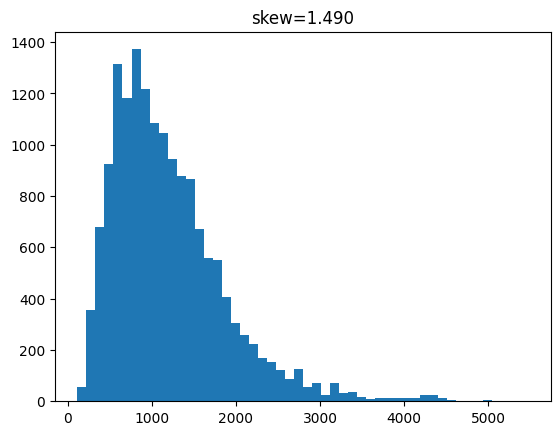

In [13]:
import matplotlib.pyplot as plt
import scipy.stats as st
plt.hist(y_train, bins=50)
plt.title(f"skew={st.skew(y_train):.3f}")
plt.show()

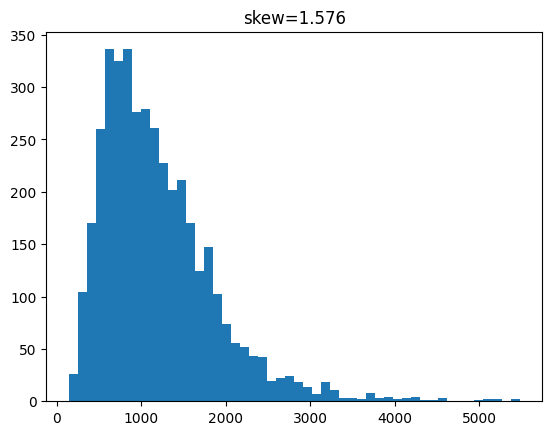

In [14]:

plt.hist(y_test, bins=50)
plt.title(f"skew={st.skew(y_test):.3f}")
plt.show()

In [13]:
y_train = np.log1p(y_train)
y_test   = np.log1p(y_test)

In [14]:
from sklearn.svm import SVR

In [17]:
import optuna
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    x_train_norm, y_train, test_size=0.20, random_state=42
)

def objective(trial):

    params = {
        "kernel": trial.suggest_categorical("kernel", ["rbf"]),
        "C": trial.suggest_float("C", 0.1, 30, log=True),
        "gamma": trial.suggest_float("gamma", 1e-3, 0.5, log=True),
        "epsilon": trial.suggest_float("epsilon", 0.05, 0.3),
    }

    model = SVR(**params)
    model.fit(X_tr, y_tr)

    preds = model.predict(X_val)

    r2 = r2_score(y_val, preds)

    trial.report(r2, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return r2


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials= 30, show_progress_bar=True)

print("Best R2:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-11-25 22:01:07,553] A new study created in memory with name: no-name-df18a31d-5e7d-4181-8a98-12512e87272a


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-25 22:01:08,933] Trial 0 finished with value: 0.9673248249167238 and parameters: {'kernel': 'rbf', 'C': 0.15365357698805188, 'gamma': 0.05613070082841058, 'epsilon': 0.19962396080482747}. Best is trial 0 with value: 0.9673248249167238.
[I 2025-11-25 22:01:09,963] Trial 1 finished with value: 0.9565197728315133 and parameters: {'kernel': 'rbf', 'C': 1.810366173178084, 'gamma': 0.027313840373013563, 'epsilon': 0.23905432741337357}. Best is trial 0 with value: 0.9673248249167238.
[I 2025-11-25 22:01:17,697] Trial 2 finished with value: 0.9852450031259801 and parameters: {'kernel': 'rbf', 'C': 2.536984440313298, 'gamma': 0.0016535163360116441, 'epsilon': 0.06316834611320045}. Best is trial 2 with value: 0.9852450031259801.
[I 2025-11-25 22:01:18,816] Trial 3 finished with value: 0.9625539421480197 and parameters: {'kernel': 'rbf', 'C': 0.527852612182596, 'gamma': 0.05324292800446008, 'epsilon': 0.22489174582461047}. Best is trial 2 with value: 0.9852450031259801.
[I 2025-11-25 2

In [18]:
best_norm = study.best_params


svr_norm = SVR(**best_norm)
svr_norm.fit(x_train_norm, y_train)

,kernel,'rbf'
,degree,3
,gamma,0.008832197604406313
,coef0,0.0
,tol,0.001
,C,27.93786060078801
,epsilon,0.05302037586421951
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [19]:

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    x_train_norm_ms, y_train, test_size=0.20, random_state=42
)

def objective(trial):

    params = {
        "kernel": trial.suggest_categorical("kernel", ["rbf"]),
        "C": trial.suggest_float("C", 0.1, 30, log=True),
        "gamma": trial.suggest_float("gamma", 1e-3, 0.5, log=True),
        "epsilon": trial.suggest_float("epsilon", 0.05, 0.3),
    }
    model = SVR(**params)
    model.fit(X_tr, y_tr)

    preds = model.predict(X_val)

    r2 = r2_score(y_val, preds)

    trial.report(r2, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return r2


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials= 30, show_progress_bar=True)

print("Best R2:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-11-25 22:02:43,888] A new study created in memory with name: no-name-7e0aed3b-3465-411b-adbb-156590c09e6e


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-25 22:02:48,457] Trial 0 finished with value: 0.9926861713511164 and parameters: {'kernel': 'rbf', 'C': 0.5075550916566149, 'gamma': 0.07912302931860549, 'epsilon': 0.059537537021796996}. Best is trial 0 with value: 0.9926861713511164.
[I 2025-11-25 22:02:52,248] Trial 1 finished with value: 0.9913118731301199 and parameters: {'kernel': 'rbf', 'C': 22.44318010060273, 'gamma': 0.0037258086996100333, 'epsilon': 0.09647159470506035}. Best is trial 0 with value: 0.9926861713511164.
[I 2025-11-25 22:02:53,285] Trial 2 finished with value: 0.9569846548832425 and parameters: {'kernel': 'rbf', 'C': 19.83215302222507, 'gamma': 0.10278696345026532, 'epsilon': 0.2533122426678414}. Best is trial 0 with value: 0.9926861713511164.
[I 2025-11-25 22:02:54,988] Trial 3 finished with value: 0.9654175130204038 and parameters: {'kernel': 'rbf', 'C': 7.529695023163268, 'gamma': 0.06587705888652862, 'epsilon': 0.20932635772522223}. Best is trial 0 with value: 0.9926861713511164.
[I 2025-11-25 22:

In [20]:
best_norm_ms = study.best_params


svr_norm_ms = SVR(**best_norm_ms)
svr_norm_ms.fit(x_train_norm_ms, y_train)

,kernel,'rbf'
,degree,3
,gamma,0.03043768505025061
,coef0,0.0
,tol,0.001
,C,4.14841368314397
,epsilon,0.06903970244698715
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [21]:
import scipy.stats 
param_distributions = {
    "C": scipy.stats.loguniform(0.1, 100),
    "epsilon": scipy.stats.uniform(0.01, 0.49),
    "gamma": ['scale', 'auto', 0.001, 0.01, 0.1, 0.5],
    "kernel": ['rbf']
}

In [22]:
from sklearn.model_selection import RandomizedSearchCV
svr = SVR()

rand_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [23]:
rand_search.fit(x_train_nmax, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,SVR()
,param_distributions,"{'C': <scipy.stats....001861288E010>, 'epsilon': <scipy.stats....0018612C42610>, 'gamma': ['scale', 'auto', ...], 'kernel': ['rbf']}"
,n_iter,20
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [24]:
best_nmax = rand_search.best_params_

svr_nmax = SVR(**best_nmax)
svr_nmax.fit(x_train_nmax,y_train)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,np.float64(31.592553907017475)
,epsilon,np.float64(0....4868021880831)
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [26]:
rand_search.fit(x_train_nm_max, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,SVR()
,param_distributions,"{'C': <scipy.stats....001861288E010>, 'epsilon': <scipy.stats....0018612C42610>, 'gamma': ['scale', 'auto', ...], 'kernel': ['rbf']}"
,n_iter,20
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [27]:
best_nm_max = rand_search.best_params_

svr_nm_max = SVR(**best_nm_max)
svr_nm_max.fit(x_train_nm_max,y_train)

,kernel,'rbf'
,degree,3
,gamma,0.5
,coef0,0.0
,tol,0.001
,C,np.float64(6.358358856676251)
,epsilon,np.float64(0....5556312006227)
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [28]:
rand_search.fit(x_train_std, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,SVR()
,param_distributions,"{'C': <scipy.stats....001861288E010>, 'epsilon': <scipy.stats....0018612C42610>, 'gamma': ['scale', 'auto', ...], 'kernel': ['rbf']}"
,n_iter,20
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [29]:
best_std = rand_search.best_params_

svr_std = SVR(**best_std)
svr_std.fit(x_train_std,y_train)

,kernel,'rbf'
,degree,3
,gamma,0.5
,coef0,0.0
,tol,0.001
,C,np.float64(6.358358856676251)
,epsilon,np.float64(0....5556312006227)
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [24]:
from sklearn.svm import SVR
svr_norm = SVR(kernel= 'rbf', C= 27.93786060078801, gamma= 0.008832197604406313, epsilon= 0.05302037586421951)
svr_norm.fit(x_train_norm,y_train)

,kernel,'rbf'
,degree,3
,gamma,0.008832197604406313
,coef0,0.0
,tol,0.001
,C,27.93786060078801
,epsilon,0.05302037586421951
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [25]:
svr_norm_ms = SVR(kernel= 'rbf', C= 4.14841368314397, gamma= 0.03043768505025061, epsilon= 0.06903970244698715)
svr_norm_ms.fit(x_train_norm_ms,y_train)

,kernel,'rbf'
,degree,3
,gamma,0.03043768505025061
,coef0,0.0
,tol,0.001
,C,4.14841368314397
,epsilon,0.06903970244698715
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [21]:
svr_nmax = SVR(C= np.float64(31.592553907017475), epsilon= np.float64(0.09494868021880831), gamma= 'scale', kernel= 'rbf')
svr_nmax.fit(x_train_nmax,y_train)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,np.float64(31.592553907017475)
,epsilon,np.float64(0....4868021880831)
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [22]:
svr_nm_max = SVR(C= np.float64(6.358358856676251), epsilon= np.float64(0.35695556312006227), gamma= 0.5, kernel= 'rbf')
svr_nm_max.fit(x_train_nm_max,y_train)

,kernel,'rbf'
,degree,3
,gamma,0.5
,coef0,0.0
,tol,0.001
,C,np.float64(6.358358856676251)
,epsilon,np.float64(0....5556312006227)
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [23]:
svr_std = SVR(C=np.float64(6.358358856676251), epsilon= np.float64(0.35695556312006227), gamma= 0.5, kernel= 'rbf')
svr_std.fit(x_train_std,y_train)

,kernel,'rbf'
,degree,3
,gamma,0.5
,coef0,0.0
,tol,0.001
,C,np.float64(6.358358856676251)
,epsilon,np.float64(0....5556312006227)
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [15]:
import joblib

# suppose your trained model is 'model'
svr_norm = joblib.load( "svr_norm.pkl")
svr_norm_ms = joblib.load( "svr_norm_ms.pkl")
svr_nmax= joblib.load("svr_nmax.pkl")
svr_nm_max=joblib.load( "svr_nm_max.pkl")
svr_std = joblib.load("svr_std.pkl")

In [16]:
y_test_pred_norm =  svr_norm.predict(x_test_norm)
y_test_pred_norm_ms =  svr_norm_ms.predict(x_test_norm_ms)
y_test_pred_nmax =  svr_nmax.predict(x_test_nmax)
y_test_pred_nm_max =  svr_nm_max.predict(x_test_nm_max)
y_test_pred_std =  svr_std.predict(x_test_std)

In [17]:
from sklearn.metrics import r2_score

results = {
    "svr_norm": [r2_score(y_train, svr_norm.predict(x_train_norm)), r2_score(y_test, svr_norm.predict(x_test_norm))],
    "svr_norm_ms": [r2_score(y_train, svr_norm_ms.predict(x_train_norm_ms)), r2_score(y_test, svr_norm_ms.predict(x_test_norm_ms))],
    "svr_nmax": [r2_score(y_train, svr_nmax.predict(x_train_nmax)), r2_score(y_test, svr_nmax.predict(x_test_nmax))],
    "svr_nm_max": [r2_score(y_train, svr_nm_max.predict(x_train_nm_max)), r2_score(y_test, svr_nm_max.predict(x_test_nm_max))],
    "svr_std": [r2_score(y_train, svr_std.predict(x_train_std)), r2_score(y_test, svr_std.predict(x_test_std))]
}

In [18]:
result_df = pd.DataFrame(results, index=["train", "test"])
result_df

,svr_norm,svr_norm_ms,svr_nmax,svr_nm_max,svr_std
train,0.996600,0.995304,0.947143,0.826019,0.317884
test,0.995866,0.994036,0.943676,0.822547,-230.693840


In [20]:
from sklearn.metrics import mean_absolute_error

results_mae = {
    "svr_norm": [mean_absolute_error(y_train, svr_norm.predict(x_train_norm)), mean_absolute_error(y_test, svr_norm.predict(x_test_norm))],
    "svr_norm_ms": [mean_absolute_error(y_train, svr_norm_ms.predict(x_train_norm_ms)), mean_absolute_error(y_test, svr_norm_ms.predict(x_test_norm_ms))],
    "svr_nmax": [mean_absolute_error(y_train, svr_nmax.predict(x_train_nmax)), mean_absolute_error(y_test, svr_nmax.predict(x_test_nmax))],
    "svr_nm_max": [mean_absolute_error(y_train, svr_nm_max.predict(x_train_nm_max)), mean_absolute_error(y_test, svr_nm_max.predict(x_test_nm_max))],
    "svr_std": [mean_absolute_error(y_train, svr_std.predict(x_train_std)), mean_absolute_error(y_test, svr_std.predict(x_test_std))]
}

result_mae_df = pd.DataFrame(results_mae, index=["train", "test"])
result_mae_df

,svr_norm,svr_norm_ms,svr_nmax,svr_nm_max,svr_std
train,0.022866,0.029388,0.067098,0.176318,0.342168
test,0.023520,0.030310,0.068326,0.178218,7.052306


In [21]:
from sklearn.metrics import mean_squared_error

results_mse = {
    "svr_norm": [mean_squared_error(y_train, svr_norm.predict(x_train_norm)), mean_squared_error(y_test, svr_norm.predict(x_test_norm))],
    "svr_norm_ms": [mean_squared_error(y_train, svr_norm_ms.predict(x_train_norm_ms)), mean_squared_error(y_test, svr_norm_ms.predict(x_test_norm_ms))],
    "svr_nmax": [mean_squared_error(y_train, svr_nmax.predict(x_train_nmax)), mean_squared_error(y_test, svr_nmax.predict(x_test_nmax))],
    "svr_nm_max": [mean_squared_error(y_train, svr_nm_max.predict(x_train_nm_max)), mean_squared_error(y_test, svr_nm_max.predict(x_test_nm_max))],
    "svr_std": [mean_squared_error(y_train, svr_std.predict(x_train_std)), mean_squared_error(y_test, svr_std.predict(x_test_std))]
}

result_mse_df = pd.DataFrame(results_mse, index=["train", "test"])
result_mse_df

,svr_norm,svr_norm_ms,svr_nmax,svr_nm_max,svr_std
train,0.001049,0.001449,0.016303,0.053663,0.210394
test,0.001252,0.001806,0.017059,0.053745,70.173029


In [22]:
result_rmse_df = np.sqrt(result_mse_df)
result_rmse_df

,svr_norm,svr_norm_ms,svr_nmax,svr_nm_max,svr_std
train,0.032383,0.038060,0.127684,0.231653,0.458687
test,0.035385,0.042501,0.130609,0.231830,8.376934


In [29]:
y_norm = np.expm1(svr_norm.predict(x_jwst_norm))
y_norm_ms = np.expm1(svr_norm_ms.predict(x_jwst_norm_ms))
y_nmax = np.expm1(svr_nmax.predict(x_jwst_nmax))
y_nm_max = np.expm1(svr_nm_max.predict(x_jwst_nm_max))
y_std = np.expm1(svr_std.predict(x_jwst_std))

In [30]:
print("SVR NORM : ", y_norm.mean(axis = 0))
print("SVR NORM MS : ", y_norm_ms.mean(axis = 0))
print("SVR NMAX: ", y_nmax.mean(axis = 0))
print("SVR NM MAX : ", y_nm_max.mean(axis = 0))
print("SVR STD : ", y_std.mean(axis = 0))

SVR NORM :  102.90899762495371
SVR NORM MS :  604.9160592600479
SVR NMAX:  1965.4373927635854
SVR NM MAX :  824.8416067792408
SVR STD :  939.8902495469888


In [36]:
print("svr norm params : ",best_norm)
print("svr norm ms params : ",best_norm_ms)
print("svr nmax params : ",best_nmax)
print("svr nm max params : ",best_nm_max)
print("svr std params : ",best_std)

svr norm params :  {'kernel': 'rbf', 'C': 27.93786060078801, 'gamma': 0.008832197604406313, 'epsilon': 0.05302037586421951}
svr norm ms params :  {'kernel': 'rbf', 'C': 4.14841368314397, 'gamma': 0.03043768505025061, 'epsilon': 0.06903970244698715}
svr nmax params :  {'C': np.float64(31.592553907017475), 'epsilon': np.float64(0.09494868021880831), 'gamma': 'scale', 'kernel': 'rbf'}
svr nm max params :  {'C': np.float64(6.358358856676251), 'epsilon': np.float64(0.35695556312006227), 'gamma': 0.5, 'kernel': 'rbf'}
svr std params :  {'C': np.float64(6.358358856676251), 'epsilon': np.float64(0.35695556312006227), 'gamma': 0.5, 'kernel': 'rbf'}


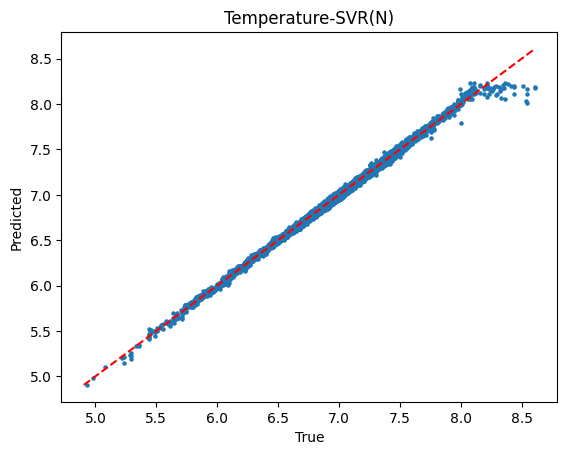

In [31]:
plt.figure()
plt.scatter(y_test, y_test_pred_norm, s=5)

m = min(y_test.min(), y_test_pred_norm.min())
M = max(y_test.max(), y_test_pred_norm.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature-SVR(N)")
plt.show()

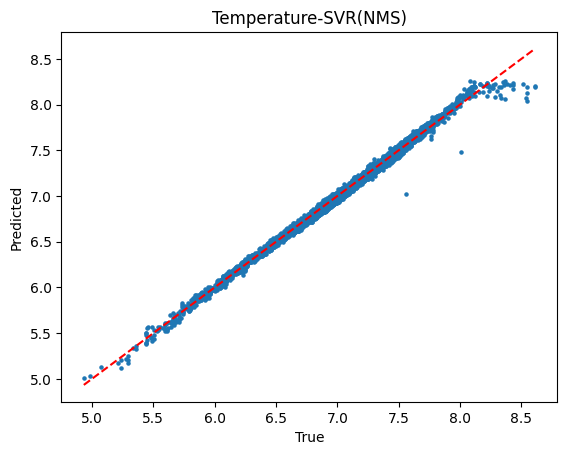

In [32]:
plt.figure()
plt.scatter(y_test, y_test_pred_norm_ms, s=5)

m = min(y_test.min(), y_test_pred_norm_ms.min())
M = max(y_test.max(), y_test_pred_norm_ms.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature-SVR(NMS)")
plt.show()

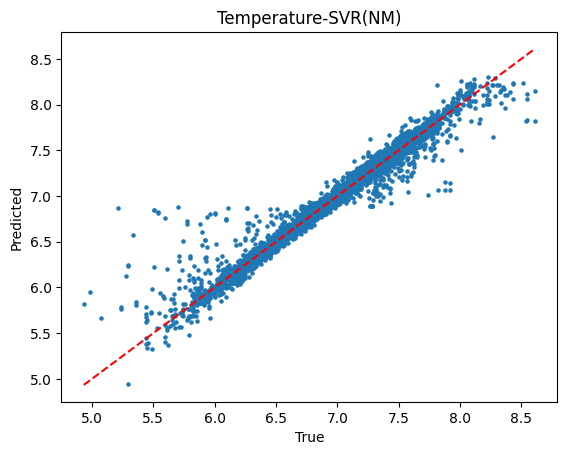

In [33]:
plt.figure()
plt.scatter(y_test, y_test_pred_nmax, s=5)

m = min(y_test.min(), y_test_pred_nmax.min())
M = max(y_test.max(), y_test_pred_nmax.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature-SVR(NM)")
plt.show()

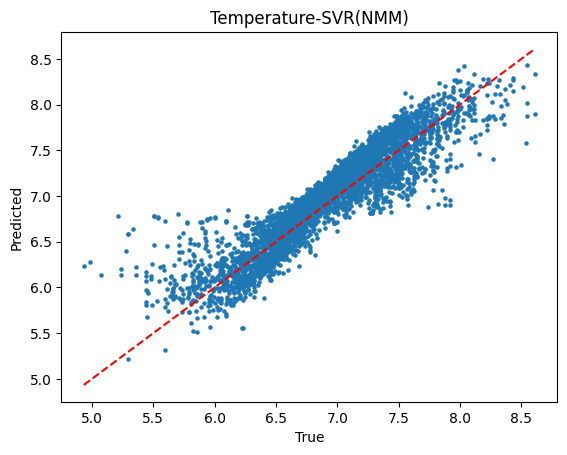

In [34]:
plt.figure()
plt.scatter(y_test, y_test_pred_nm_max, s=5)

m = min(y_test.min(), y_test_pred_nm_max.min())
M = max(y_test.max(), y_test_pred_nm_max.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature-SVR(NMM)")
plt.show()

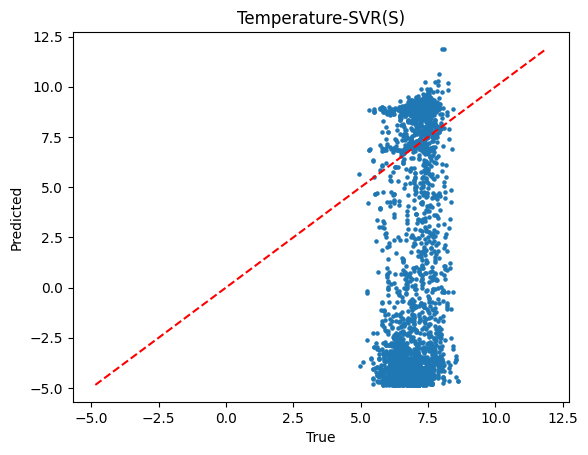

In [35]:
plt.figure()
plt.scatter(y_test, y_test_pred_std, s=5)

m = min(y_test.min(), y_test_pred_std.min())
M = max(y_test.max(), y_test_pred_std.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature-SVR(S)")
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\1344094133.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\1344094133.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\1344094133.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

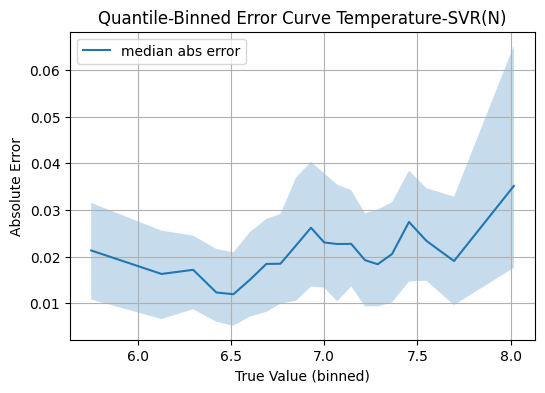

In [36]:
true = y_test       # 1D array
pred = y_test_pred_norm  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature-SVR(N)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\2311476853.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\2311476853.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\2311476853.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

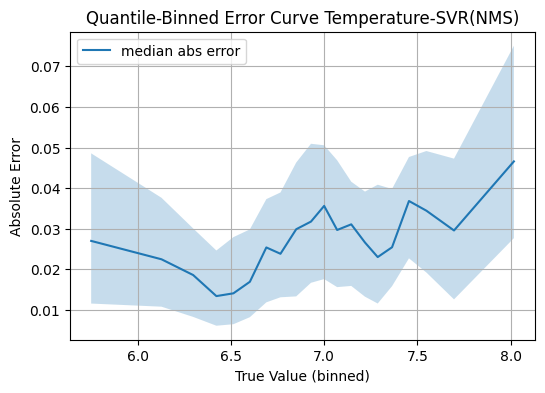

In [37]:
true = y_test       # 1D array
pred = y_test_pred_norm_ms  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature-SVR(NMS)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\3654641504.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\3654641504.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\3654641504.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

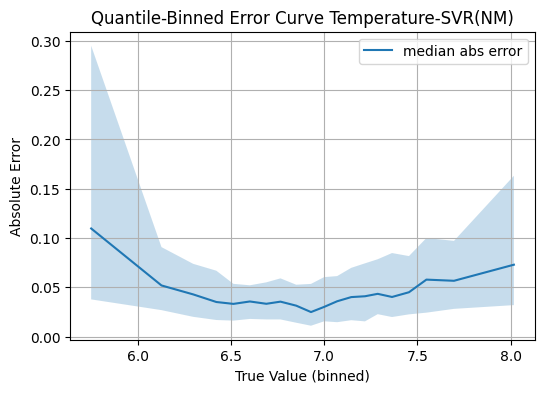

In [38]:
true = y_test       # 1D array
pred = y_test_pred_nmax  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature-SVR(NM)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\1008199480.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\1008199480.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\1008199480.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

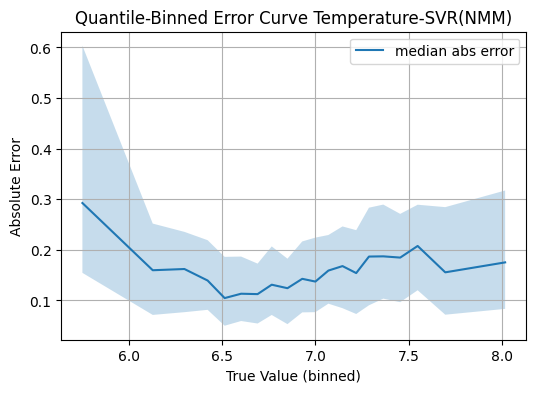

In [39]:
true = y_test       # 1D array
pred = y_test_pred_nm_max  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature-SVR(NMM)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\617084477.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\617084477.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_5744\617084477.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence

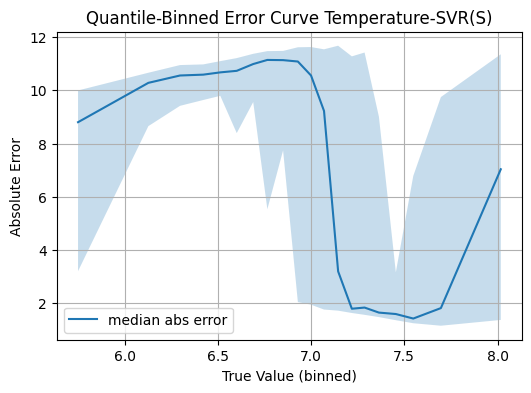

In [40]:
true = y_test       # 1D array
pred = y_test_pred_std  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature-SVR(S)")
plt.legend()
plt.grid(True)
plt.show()

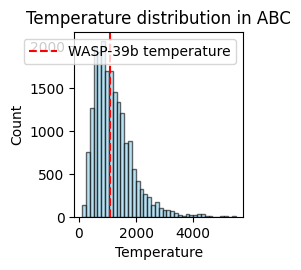

In [47]:
plt.subplot(2, 3, 1)
plt.hist(y, bins=40, alpha=0.6, color='skyblue', edgecolor='k')
plt.axvline(1100, color='red', linestyle='--', label= "WASP-39b temperature")
plt.title(f"Temperature distribution in ABC")
plt.xlabel("Temperature")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
import joblib

# suppose your trained model is 'model'
joblib.dump(svr_norm, "svr_norm.pkl")
joblib.dump(svr_norm_ms, "svr_norm_ms.pkl")
joblib.dump(svr_nmax, "svr_nmax.pkl")
joblib.dump(svr_nm_max, "svr_nm_max.pkl")
joblib.dump(svr_std, "svr_std.pkl")

['svr_std.pkl']